# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Input
from tensorflow.keras.utils import pad_sequences


In [2]:
df = pd.read_csv('mathurance.csv')

fixing the data format

In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df['règlement'] = df['règlement'].str.replace(',', '').astype(float)
df["date_survenance"] = pd.to_datetime(df["date_survenance"])
df = df.drop(columns=["désignation_produit"])
df = df.drop(columns=["branche"])

/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/2599869940.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date_survenance"] = pd.to_datetime(df["date_survenance"])


In [4]:
df.head()

,exercice,code_produit,sous-branche,date_survenance,règlement
0,2021,IN,Incendie,2019-10-14,3.058432e+09
1,2018,IN,Incendie,2017-03-14,2.972783e+09
2,2019,IN,Incendie,2017-06-17,2.611499e+09
3,2016,IN,Incendie,2015-01-27,2.547476e+09
4,2022,IN,Incendie,2021-01-04,2.057632e+09


Splitting the data based on 'sous-branche'

In [5]:
df_cat_nat = df[df['sous-branche'] == 'CAT-NAT']
df_incendie = df[df['sous-branche'] == 'Incendie']
df_responsabilite_civile = df[df['sous-branche'] == 'Responsabilité Civile']
df_risque_simple = df[df['sous-branche'] == 'Risque simple']

In [6]:
df_risque_simple = df_risque_simple.drop(columns=["sous-branche"])
df_cat_nat = df_cat_nat.drop(columns=["sous-branche"])
df_incendie = df_incendie.drop(columns=["sous-branche"])
df_responsabilite_civile = df_responsabilite_civile.drop(columns=["sous-branche"])

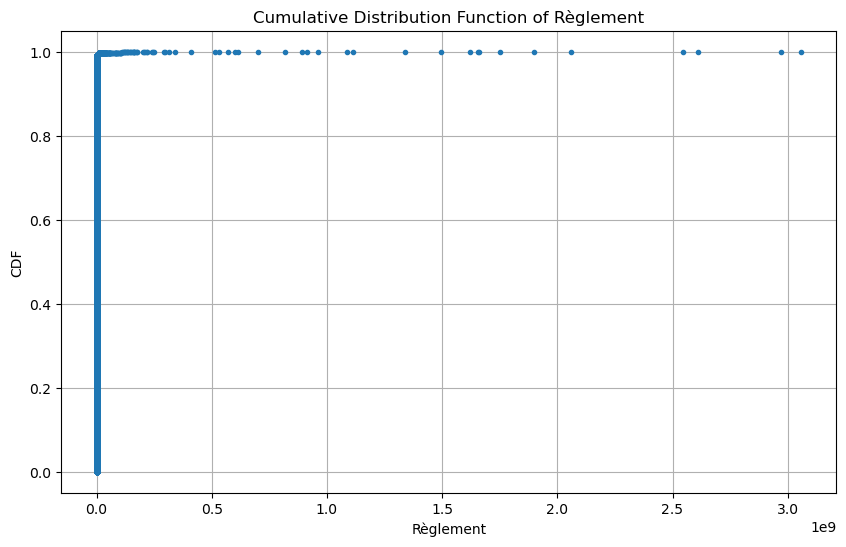

In [7]:
import numpy as np

import matplotlib.pyplot as plt

# Sort the data
data_sorted = np.sort(df['règlement'])

# Calculate the CDF
cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(data_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('Règlement')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Règlement')
plt.grid(True)
plt.show()

we notice that the CDF is very hard to determine, we need to find a scale to reduce the variance

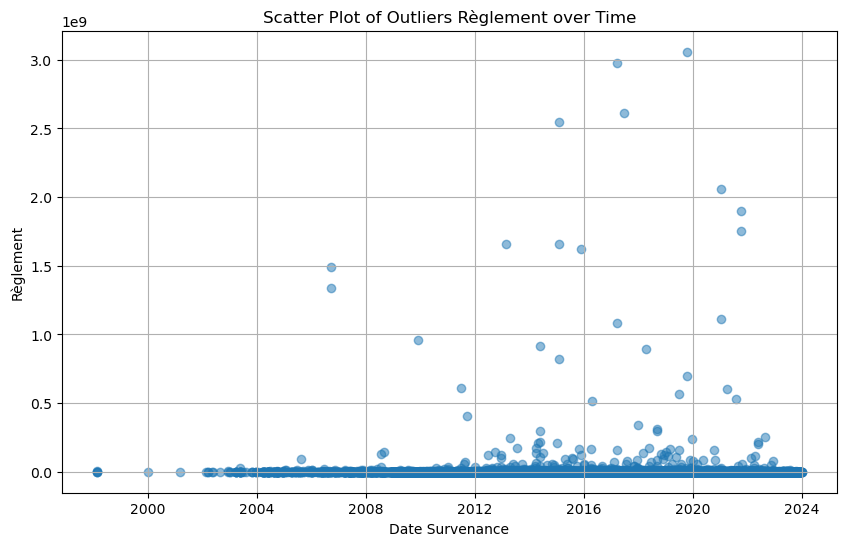

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['date_survenance'], df['règlement'], alpha=0.5)
plt.xlabel('Date Survenance')
plt.ylabel('Règlement')
plt.title('Scatter Plot of Outliers Règlement over Time')
plt.grid(True)
plt.show()

these are not outliers!! we should keep them, let's apply the scale and see the new behavior

In [9]:
df['log_règlement'] = np.log(df['règlement'])
df.head()

,exercice,code_produit,sous-branche,date_survenance,règlement,log_règlement
0,2021,IN,Incendie,2019-10-14,3.058432e+09,21.841168
1,2018,IN,Incendie,2017-03-14,2.972783e+09,21.812764
2,2019,IN,Incendie,2017-06-17,2.611499e+09,21.683190
3,2016,IN,Incendie,2015-01-27,2.547476e+09,21.658369
4,2022,IN,Incendie,2021-01-04,2.057632e+09,21.444822


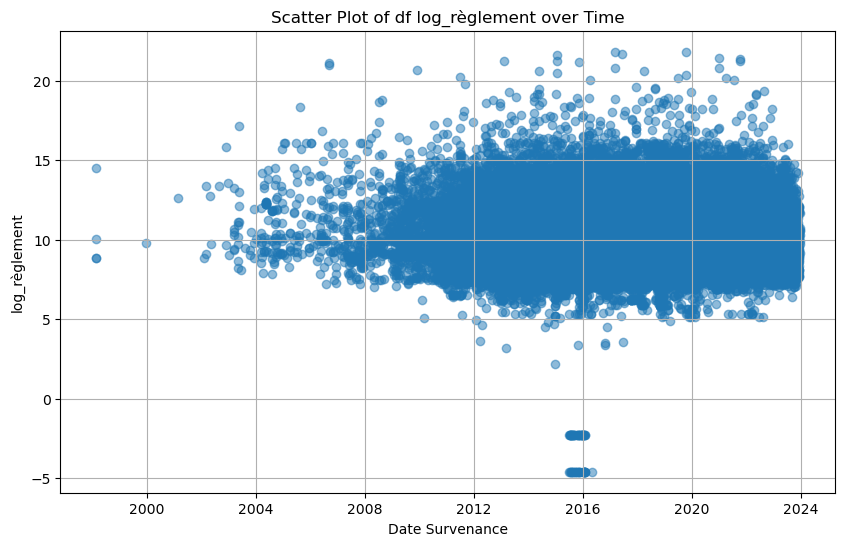

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['date_survenance'], df['log_règlement'], alpha=0.5)
plt.xlabel('Date Survenance')
plt.ylabel('log_règlement')
plt.title('Scatter Plot of df log_règlement over Time')
plt.grid(True)
plt.show()

### ALLRIGHT !! we can see that the scale really worked well !!

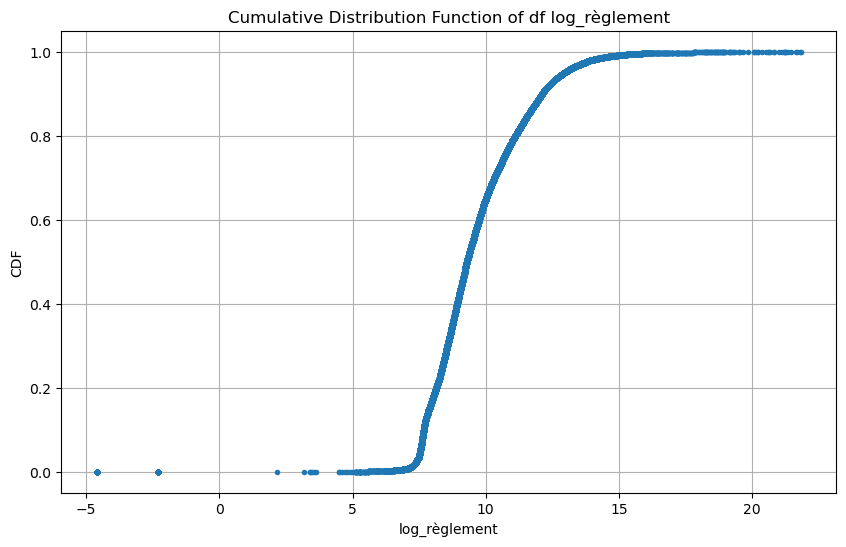

In [11]:
# Sort the data
df_sorted = np.sort(df['log_règlement'])

# Calculate the CDF
df_cdf = np.arange(1, len(df_sorted) + 1) / len(df_sorted)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(df_sorted, df_cdf, marker='.', linestyle='none')
plt.xlabel('log_règlement')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of df log_règlement')
plt.grid(True)
plt.show()

we should find the elbow point

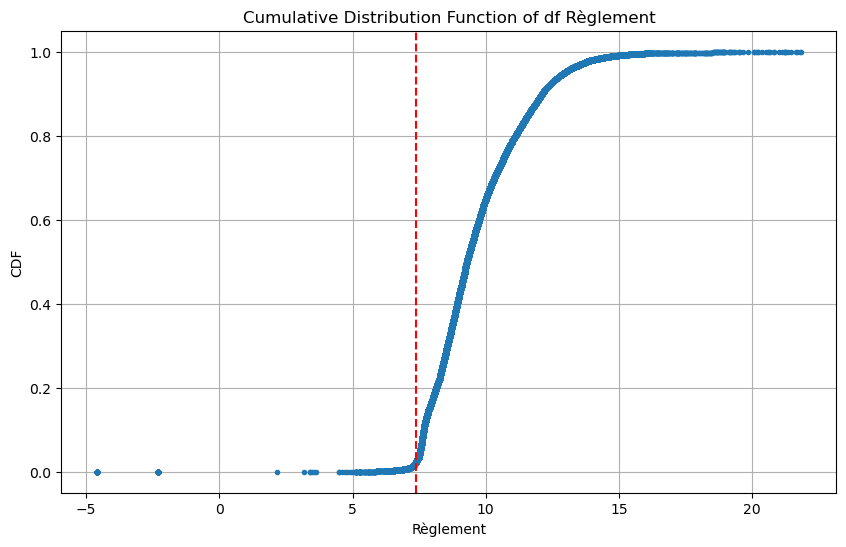

In [12]:
# Sort the data
df_sorted = np.sort(df['log_règlement'])

# Calculate the CDF
df_cdf = np.arange(1, len(df_sorted) + 1) / len(df_sorted)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(df_sorted, df_cdf, marker='.', linestyle='none')
plt.axvline(x=7.4, color='red', linestyle='--')
plt.xlabel('Règlement')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of df Règlement')
plt.grid(True)
plt.show()

In [13]:
df_above_elbow = df[df['log_règlement'] > 7.4] # elbow point

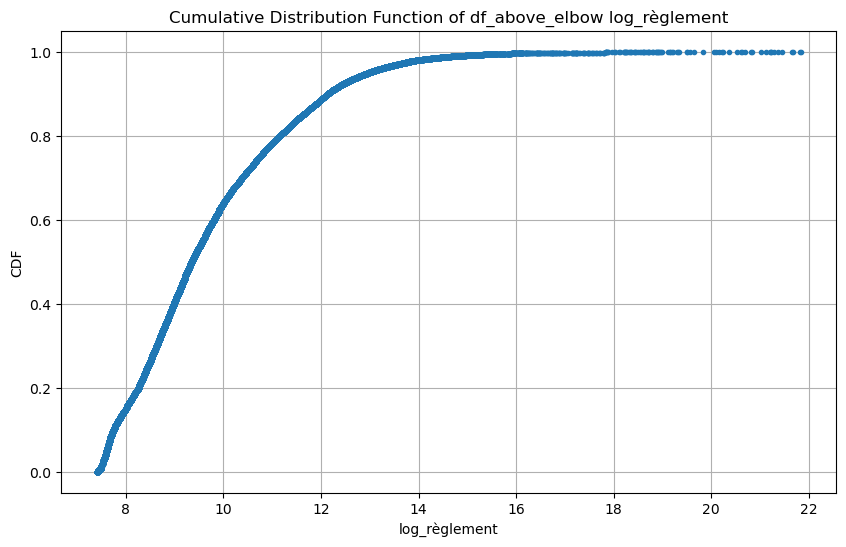

In [14]:
# Sort the data
df_above_elbow_sorted = np.sort(df_above_elbow['log_règlement'])

# Calculate the CDF
df_above_elbow_cdf = np.arange(1, len(df_above_elbow_sorted) + 1) / len(df_above_elbow_sorted)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(df_above_elbow_sorted, df_above_elbow_cdf, marker='.', linestyle='none')
plt.xlabel('log_règlement')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of df_above_elbow log_règlement')
plt.grid(True)
plt.show()

In [15]:
len(df_above_elbow)

87841

we drop few records that are very close to zero value by keeping only records above the elbow value

In [16]:
df_chain_ladder = df_above_elbow[['exercice','code_produit', 'sous-branche' ,'date_survenance', 'log_règlement']]
df_chain_ladder.head()

,exercice,code_produit,sous-branche,date_survenance,log_règlement
0,2021,IN,Incendie,2019-10-14,21.841168
1,2018,IN,Incendie,2017-03-14,21.812764
2,2019,IN,Incendie,2017-06-17,21.683190
3,2016,IN,Incendie,2015-01-27,21.658369
4,2022,IN,Incendie,2021-01-04,21.444822


Now, preparing the data for the chain ladder method and other methods

In [17]:
df_chain_ladder['date_survenance'] = df_chain_ladder['date_survenance'].dt.year # only year is needed
df_chain_ladder.head()

/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/147996996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chain_ladder['date_survenance'] = df_chain_ladder['date_survenance'].dt.year # only year is needed


,exercice,code_produit,sous-branche,date_survenance,log_règlement
0,2021,IN,Incendie,2019,21.841168
1,2018,IN,Incendie,2017,21.812764
2,2019,IN,Incendie,2017,21.683190
3,2016,IN,Incendie,2015,21.658369
4,2022,IN,Incendie,2021,21.444822


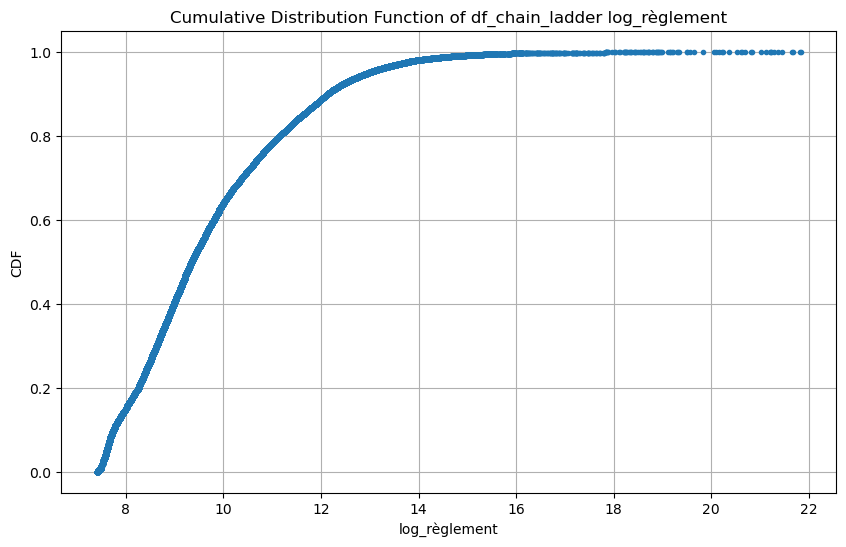

In [18]:
# Sort the data
df_chain_ladder_sorted = np.sort(df_chain_ladder['log_règlement'])

# Calculate the CDF
df_chain_ladder_cdf = np.arange(1, len(df_chain_ladder_sorted) + 1) / len(df_chain_ladder_sorted)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(df_chain_ladder_sorted, df_chain_ladder_cdf, marker='.', linestyle='none')
plt.xlabel('log_règlement')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of df_chain_ladder log_règlement')
plt.grid(True)
plt.show()

in order to see the distribution of 'règlement' we notice the nex plots

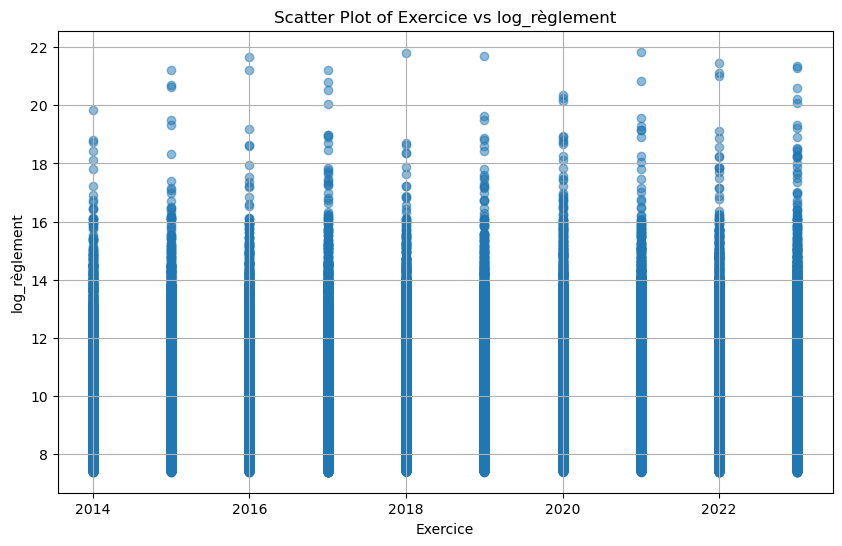

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df_chain_ladder['exercice'], df_chain_ladder['log_règlement'], alpha=0.5)
plt.xlabel('Exercice')
plt.ylabel('log_règlement')
plt.title('Scatter Plot of Exercice vs log_règlement')
plt.grid(True)
plt.show()

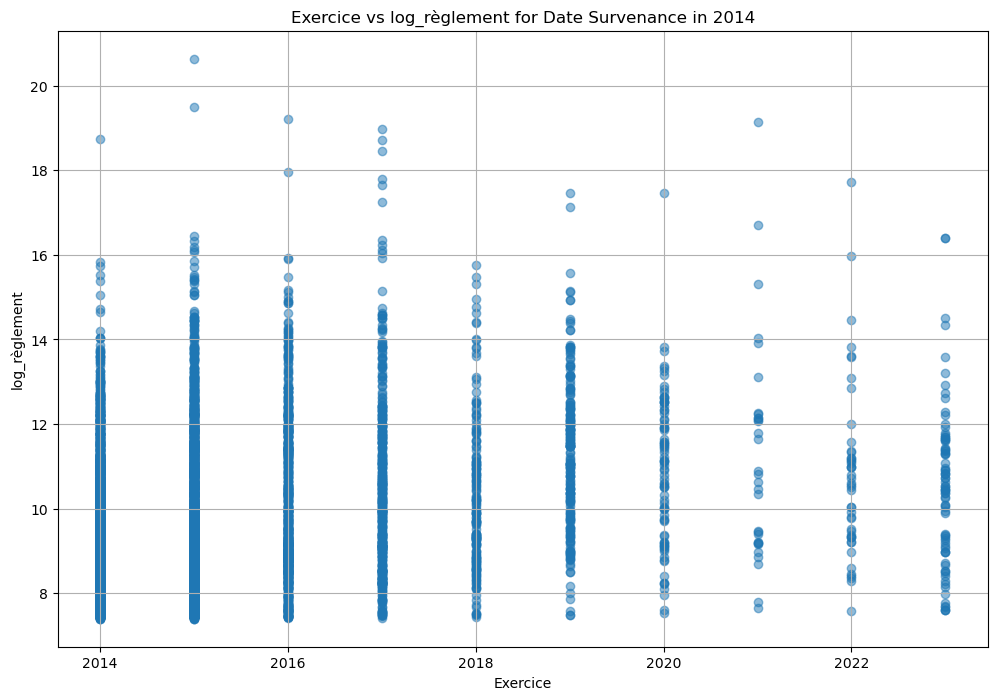

In [20]:
# Filter the dataframe for date_survenance in the year 2014
df_chain_ladder_2014 = df_chain_ladder[df_chain_ladder['date_survenance'] == 2014]

# Plot the data
plt.figure(figsize=(12, 8))
plt.scatter(df_chain_ladder_2014['exercice'], df_chain_ladder_2014['log_règlement'], alpha=0.5)
plt.xlabel('Exercice')
plt.ylabel('log_règlement')
plt.title('Exercice vs log_règlement for Date Survenance in 2014')
plt.grid(True)
plt.show()

In [21]:
len(df_chain_ladder_2014)


7645

take a look at the distribution of exrcice for a given survenance year

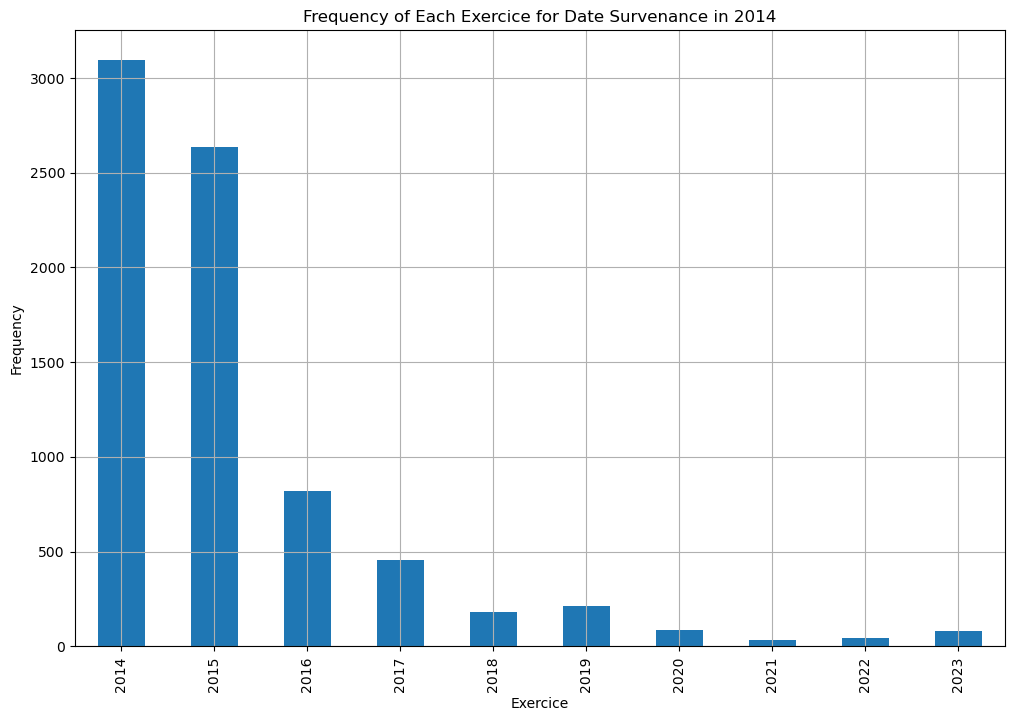

In [22]:
# Filter the dataframe for date_survenance in the year 2014
df_chain_ladder_2014 = df_chain_ladder[df_chain_ladder['date_survenance'] == 2014]

# Plot the frequency of each exercice
plt.figure(figsize=(12, 8))
df_chain_ladder_2014['exercice'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Exercice')
plt.ylabel('Frequency')
plt.title('Frequency of Each Exercice for Date Survenance in 2014')
plt.grid(True)
plt.show()

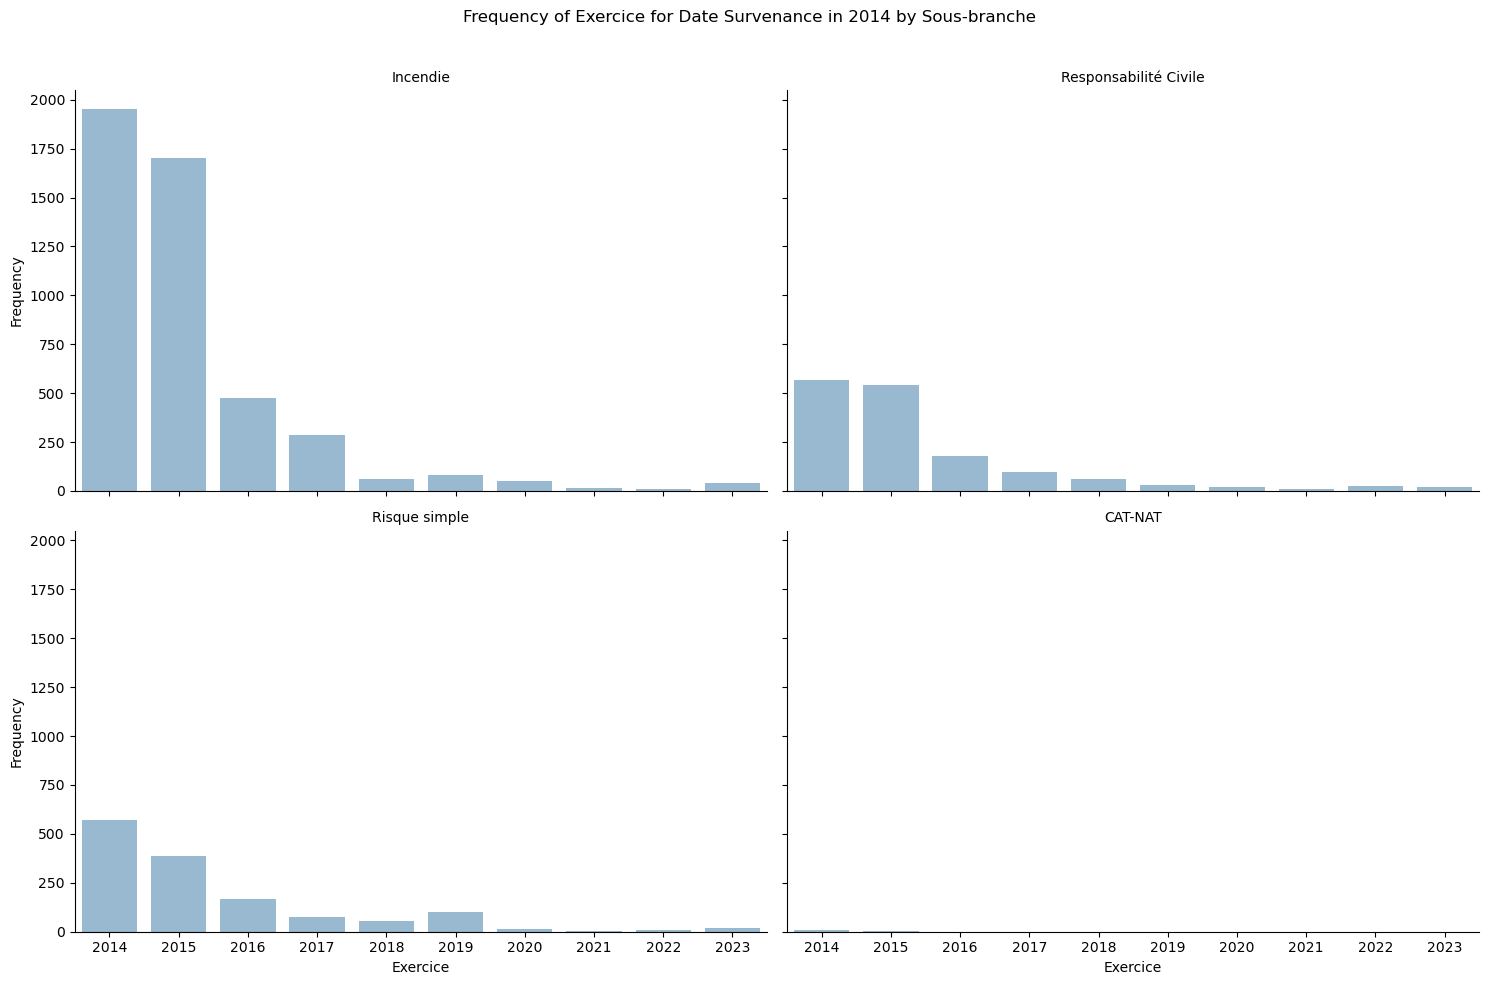

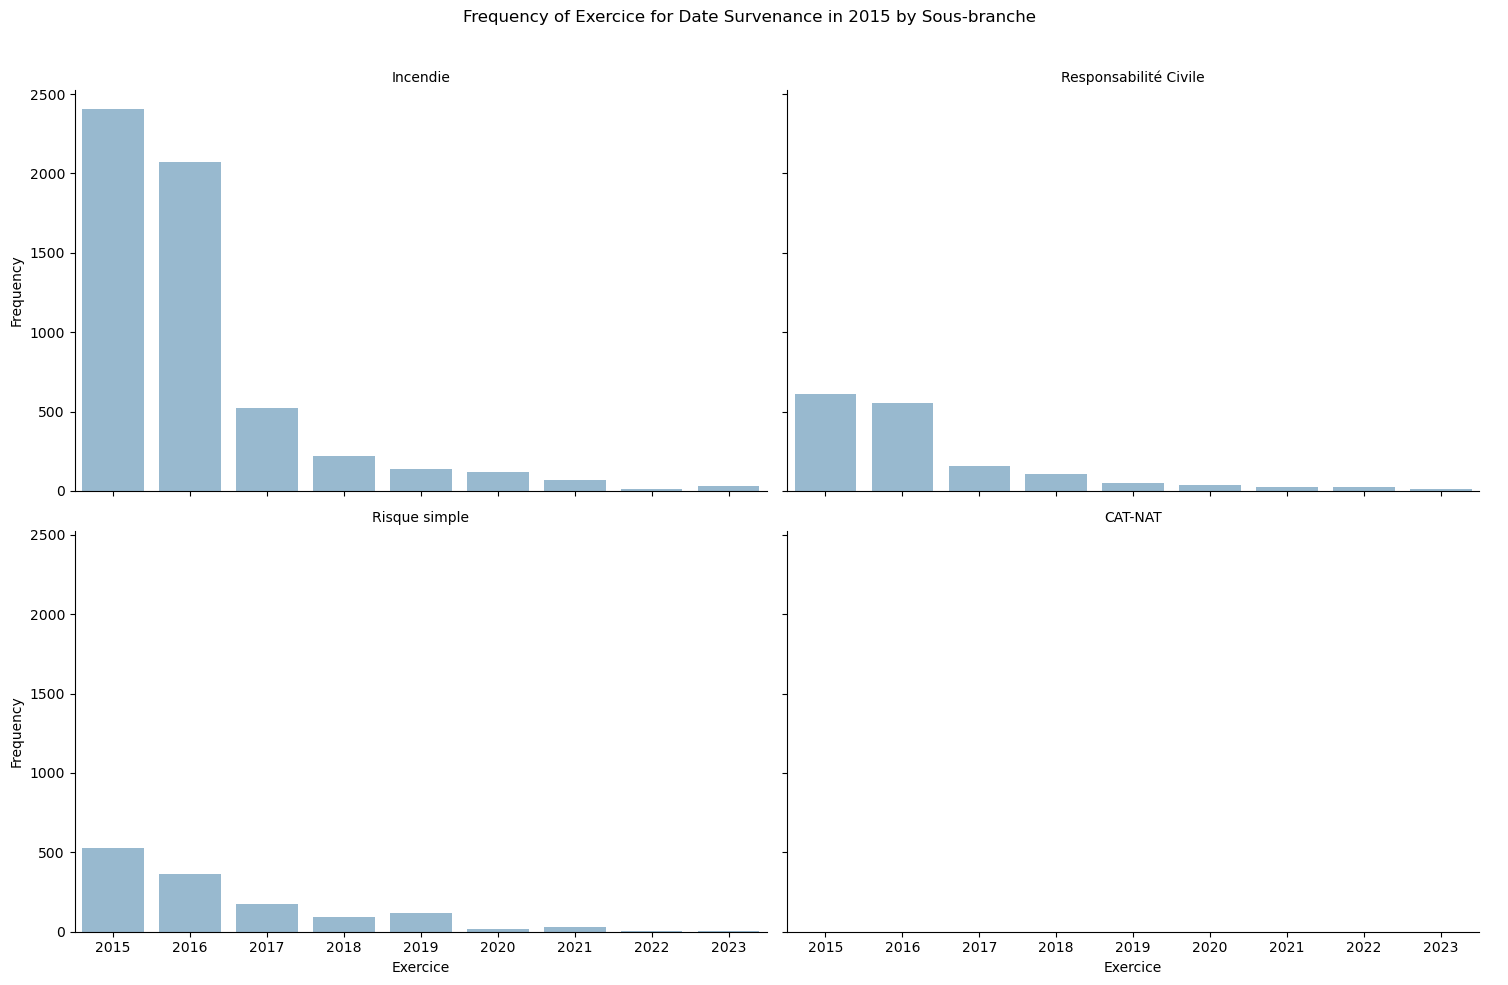

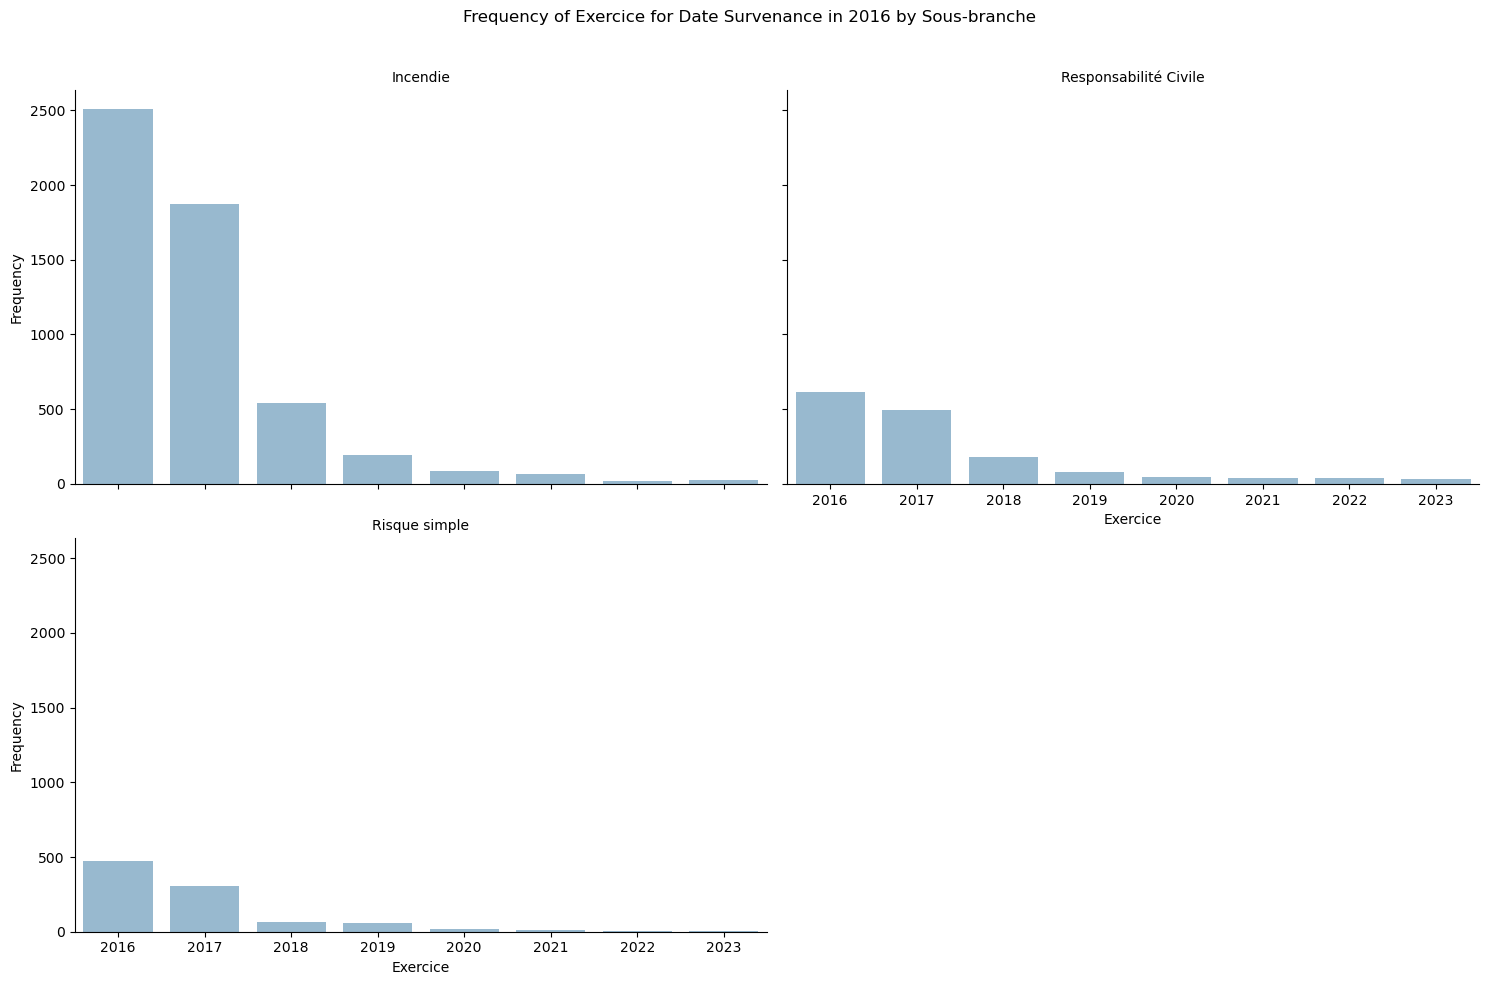

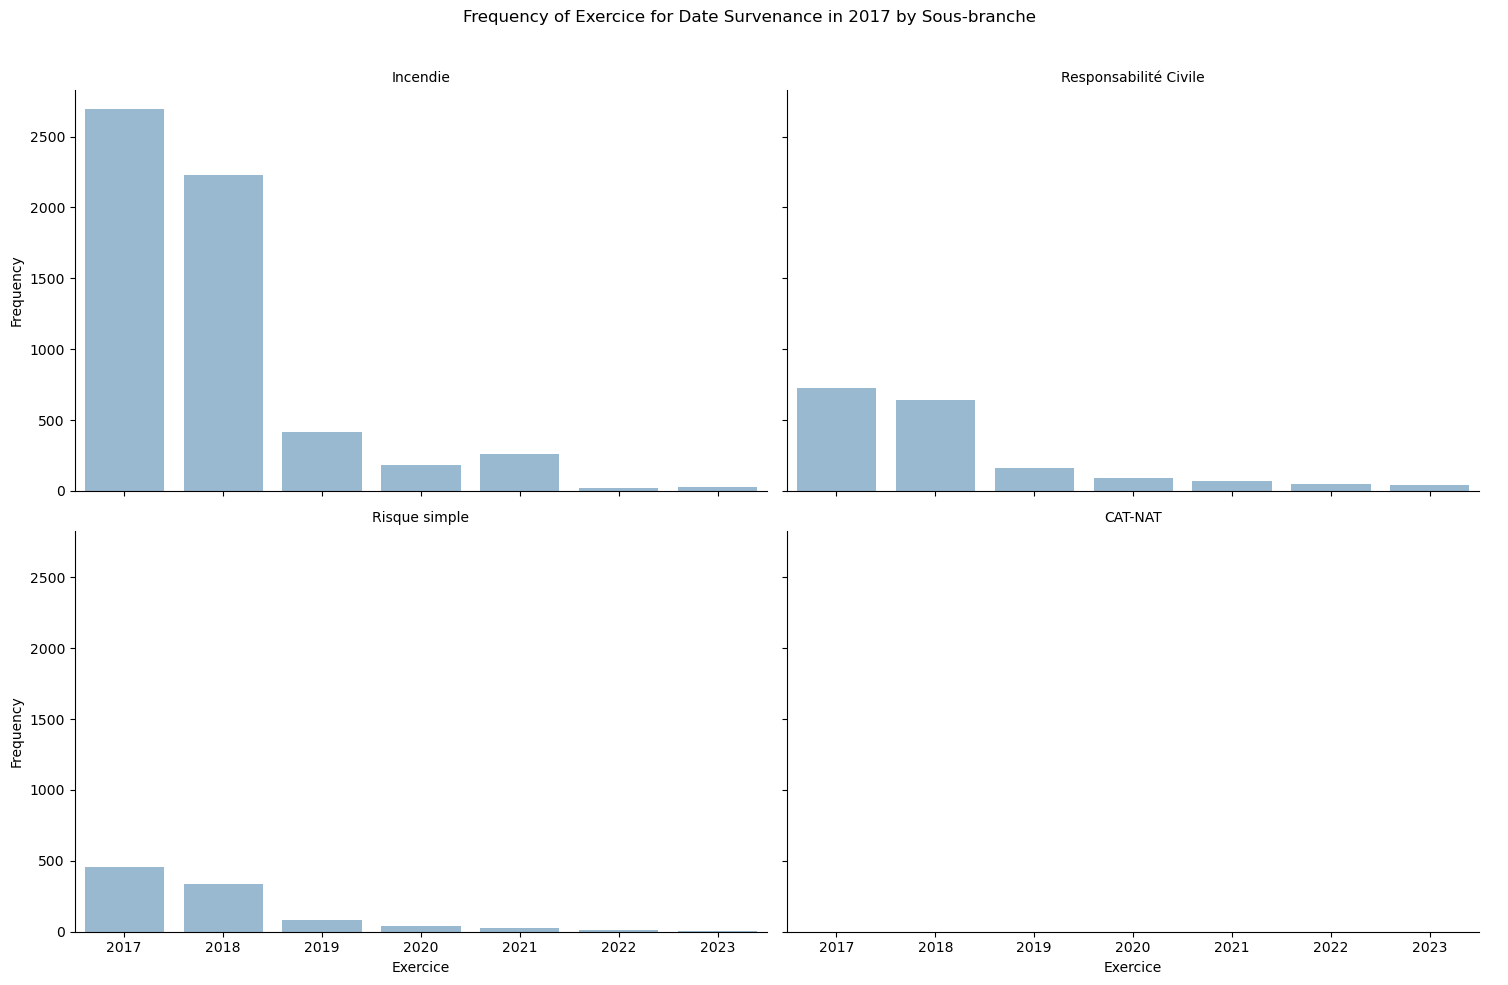

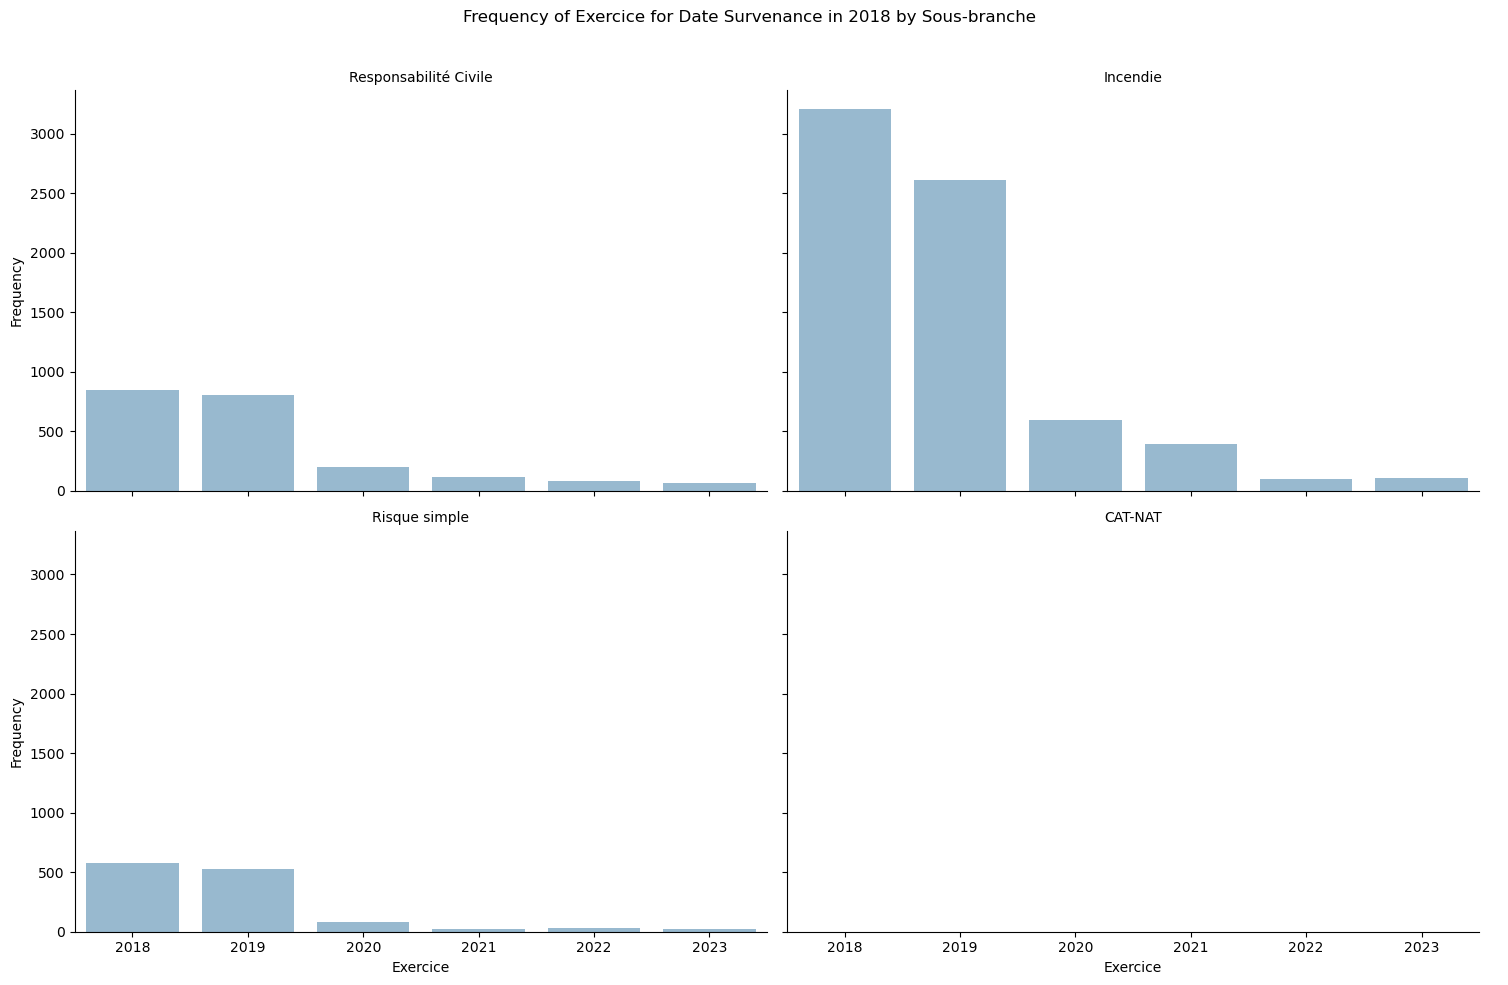

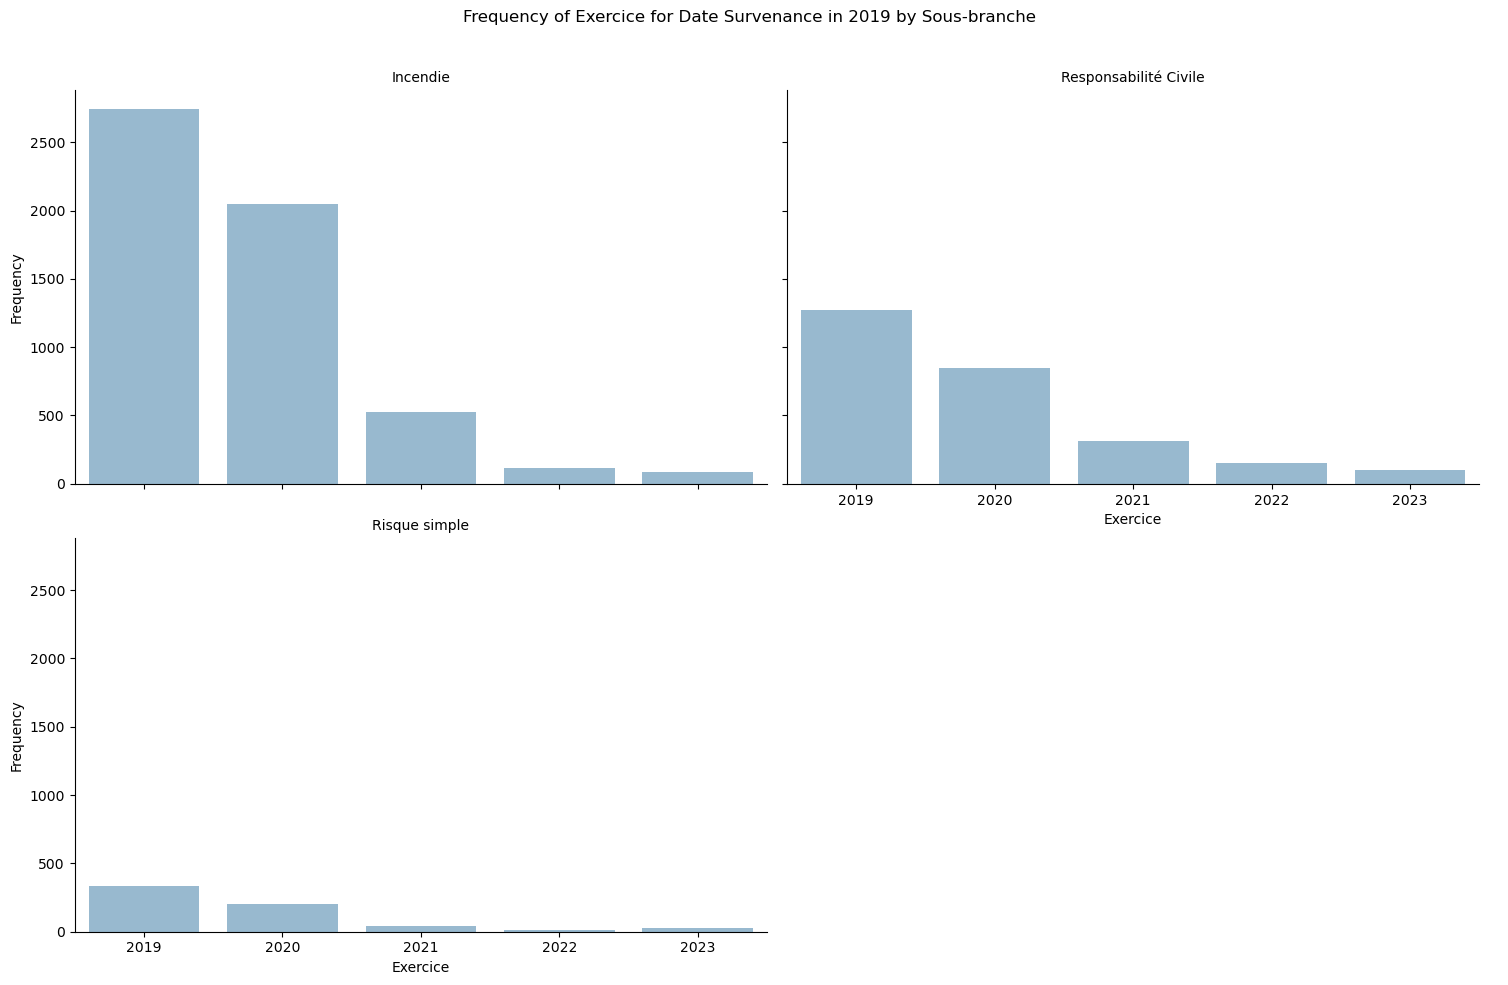

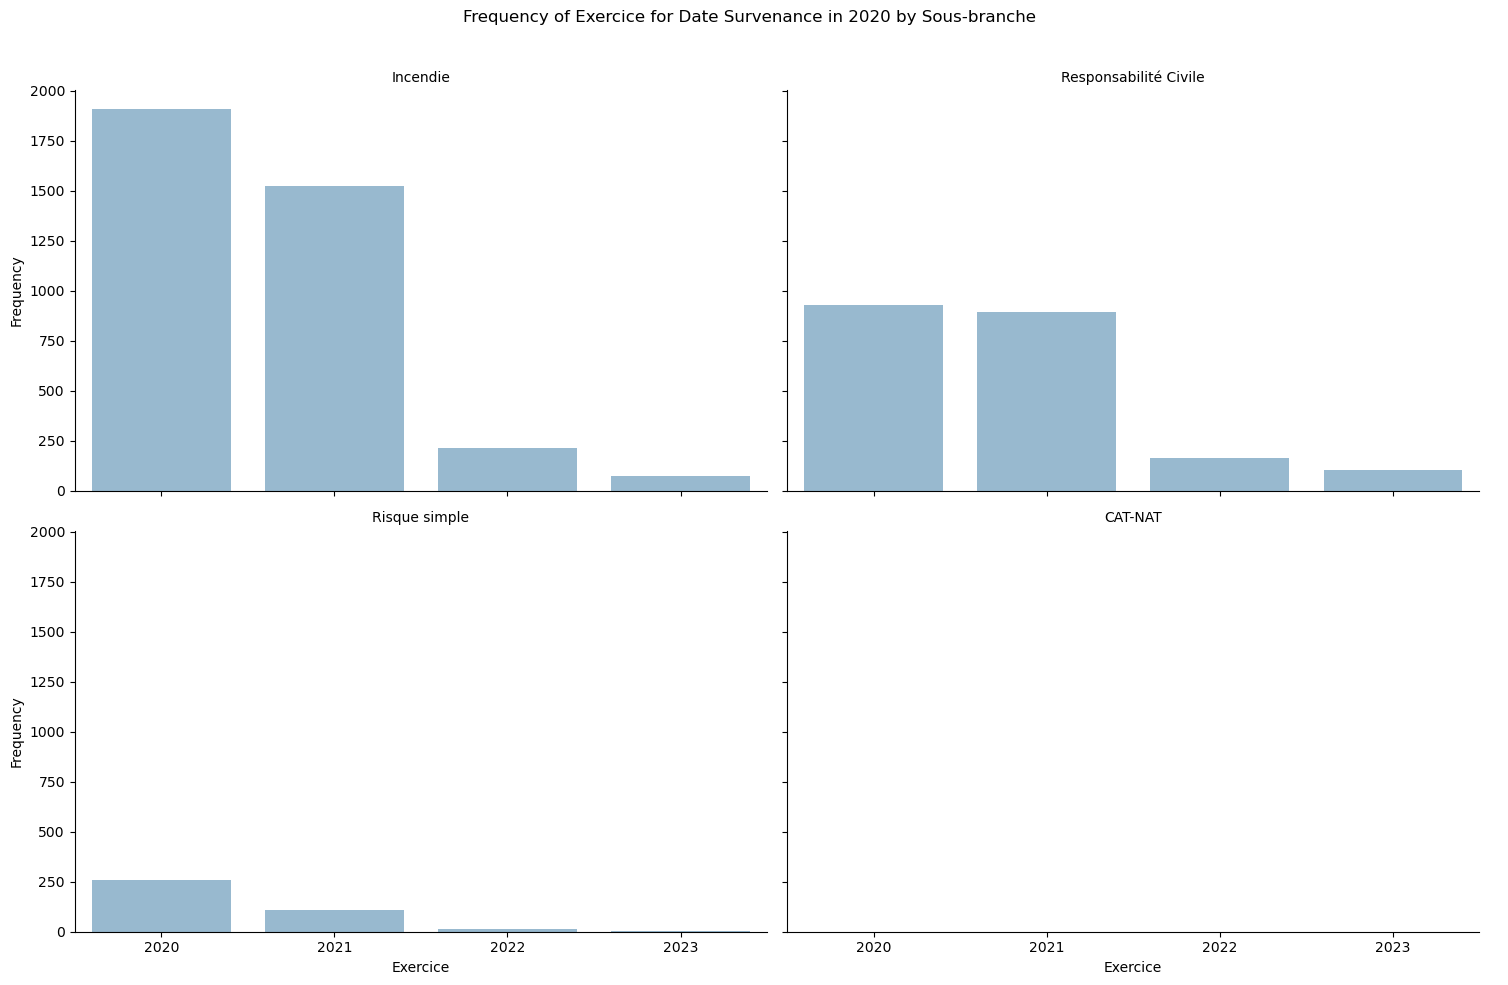

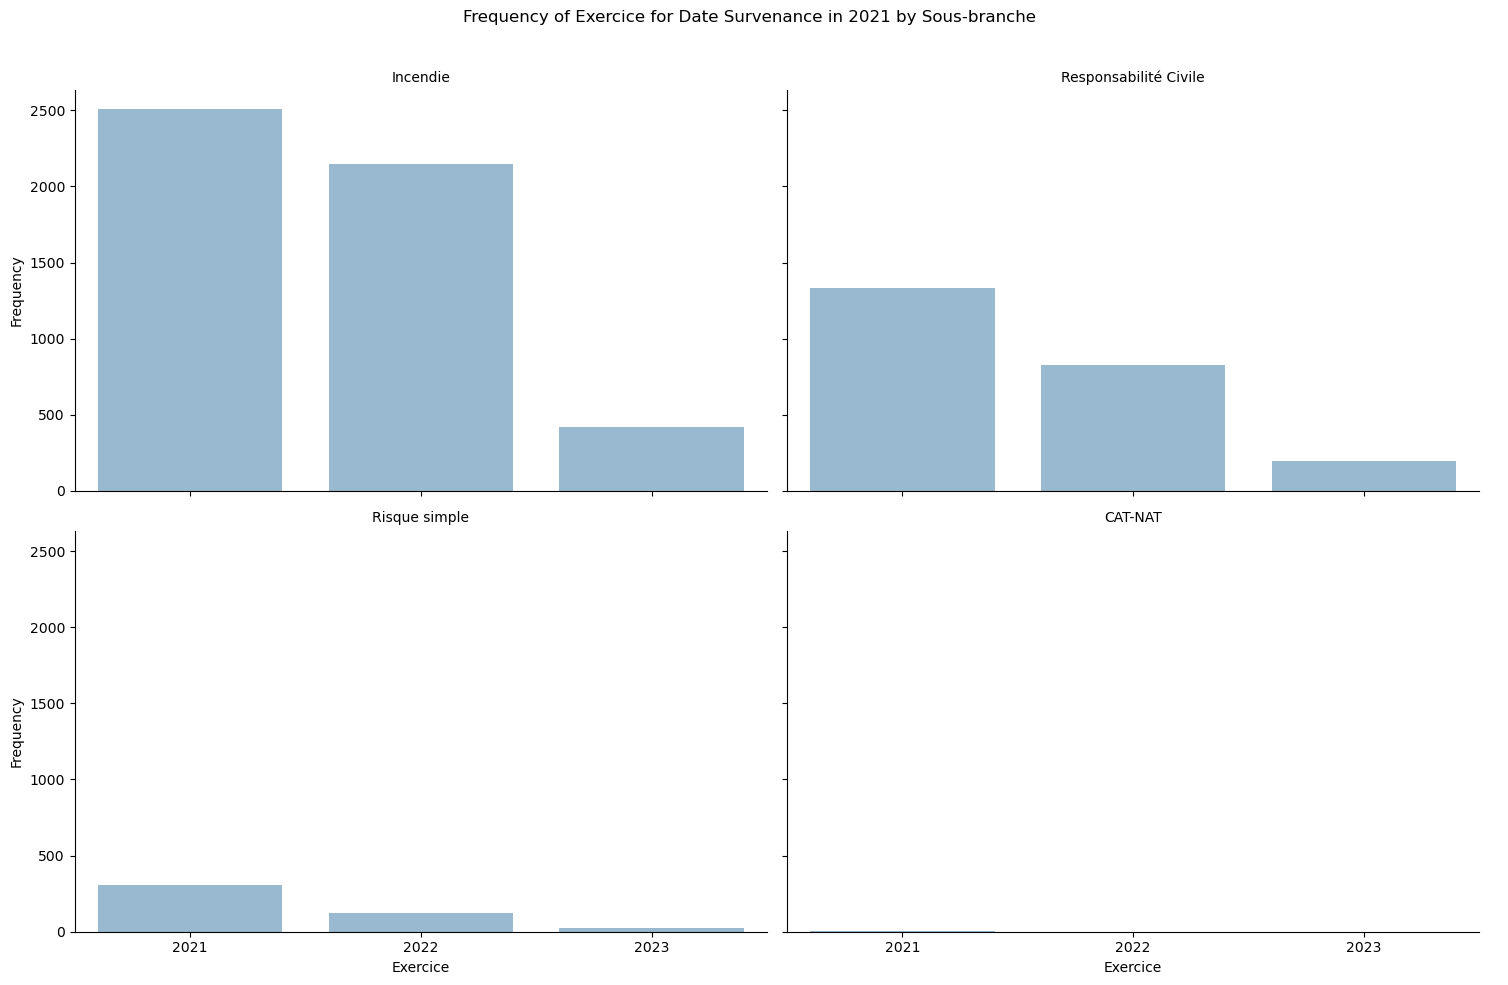

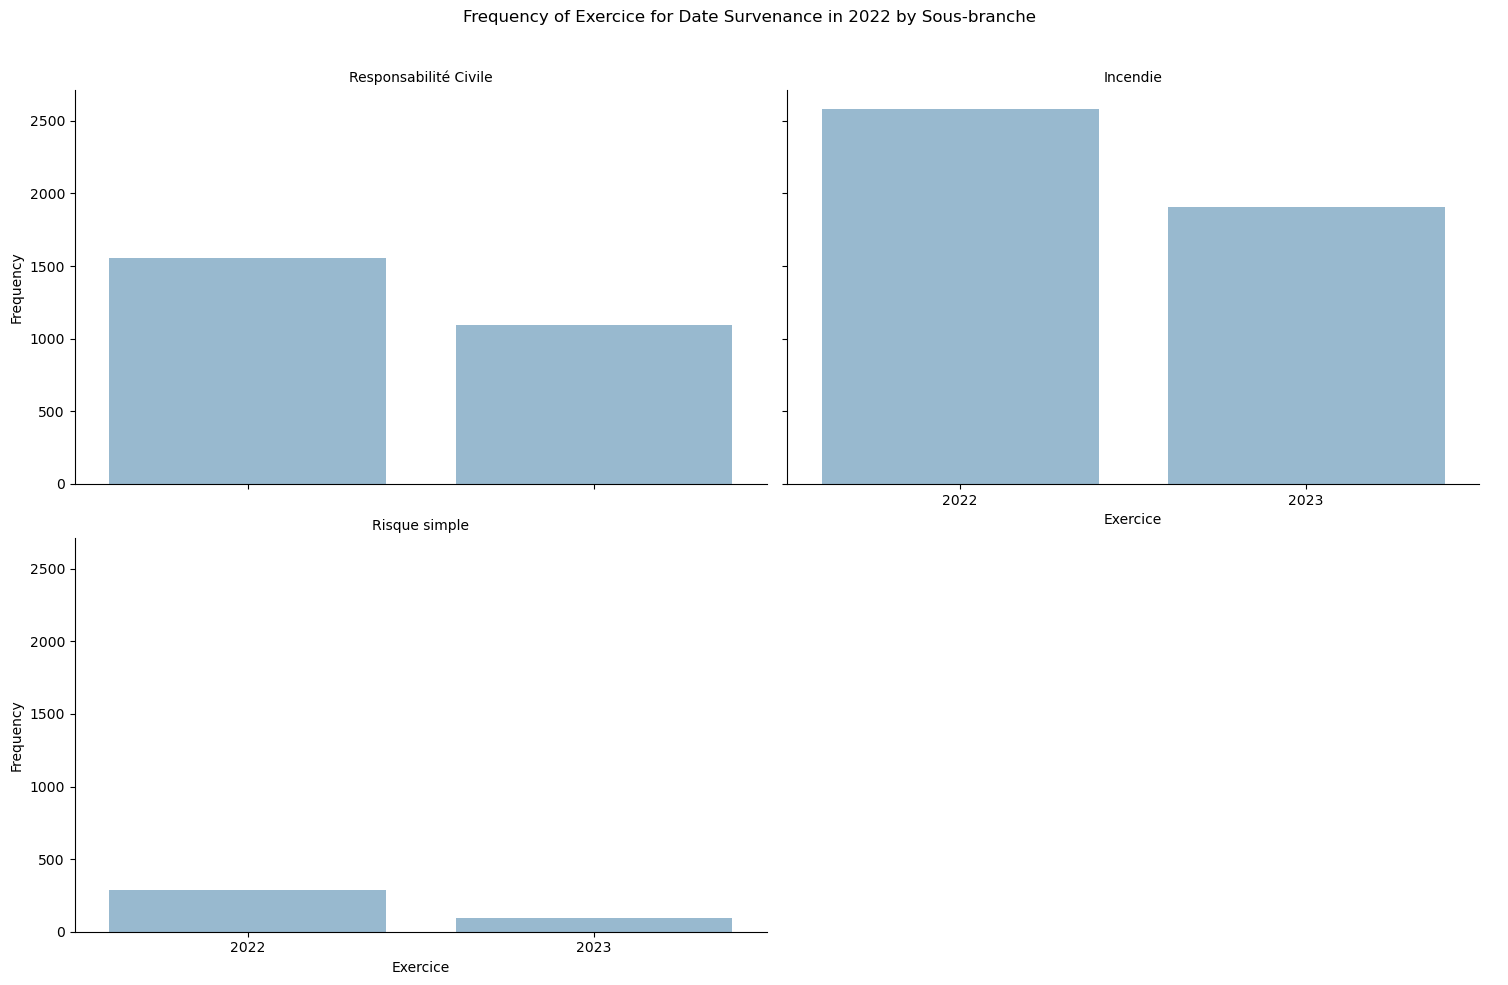

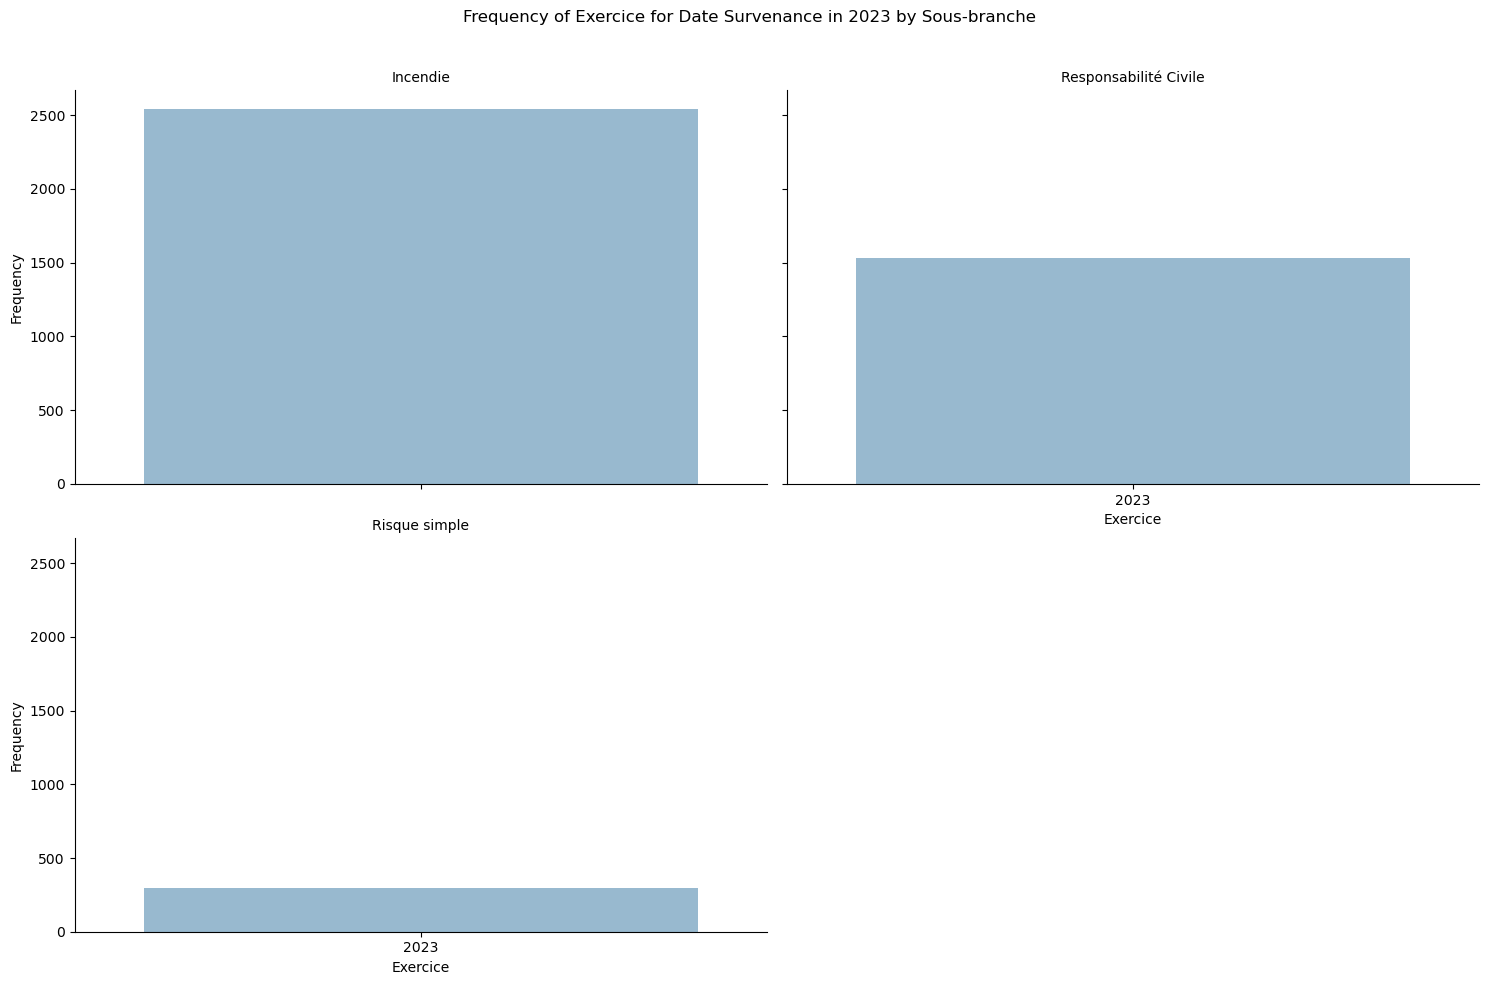

In [23]:
import seaborn as sns

# Loop through each year from 2014 to 2023
for year in range(2014, 2024):
    # Filter the dataframe for the current year
    df_chain_ladder_year = df_chain_ladder[df_chain_ladder['date_survenance'] == year]
    
    # Create a FacetGrid to plot the data for each 'sous-branche'
    g = sns.FacetGrid(df_chain_ladder_year, col="sous-branche", col_wrap=2, height=5, aspect=1.5)
    g.map_dataframe(sns.countplot, x="exercice", alpha=0.5)
    g.set_axis_labels("Exercice", "Frequency")
    g.set_titles(col_template="{col_name}")
    g.add_legend()

    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Frequency of Exercice for Date Survenance in {year} by Sous-branche')
    plt.show()


### All the Years follows the same distribution as the plots show above!!

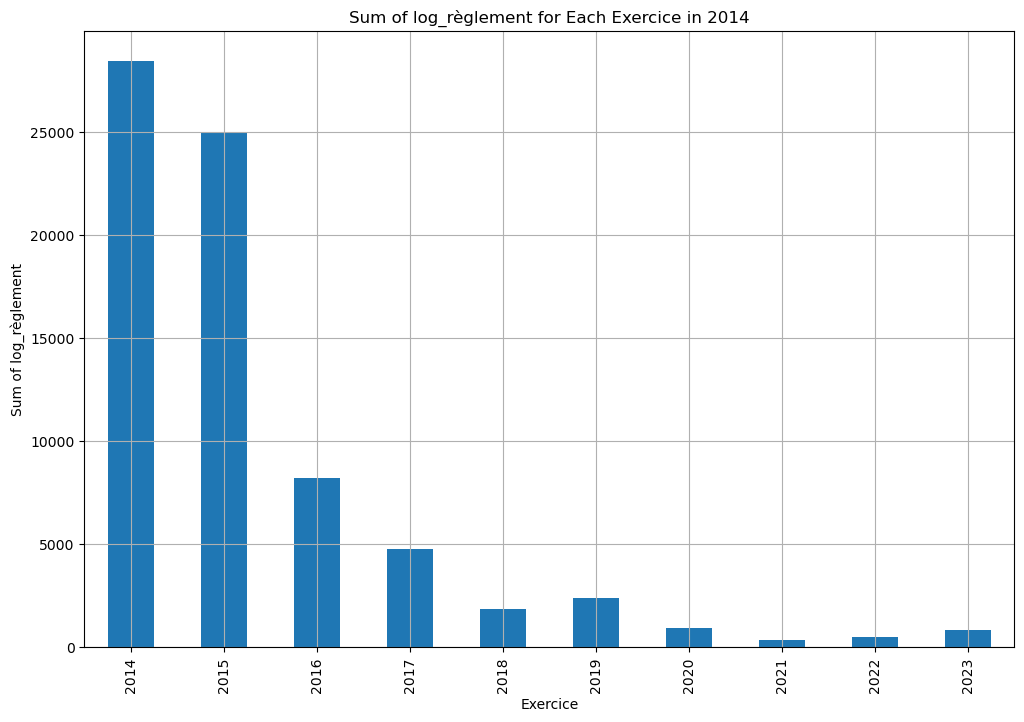

In [24]:
# Filter the dataframe for date_survenance in the year 2014
df_2014 = df_chain_ladder[df_chain_ladder['date_survenance'] == 2014]

# Group by 'exercice' and calculate the sum of 'log_règlement'
sum_log_reglement = df_2014.groupby('exercice')['log_règlement'].sum()

# Plot the data
plt.figure(figsize=(12, 8))
sum_log_reglement.plot(kind='bar')
plt.xlabel('Exercice')
plt.ylabel('Sum of log_règlement')
plt.title('Sum of log_règlement for Each Exercice in 2014')
plt.grid(True)
plt.show()

this is the amount of total reglement for each year

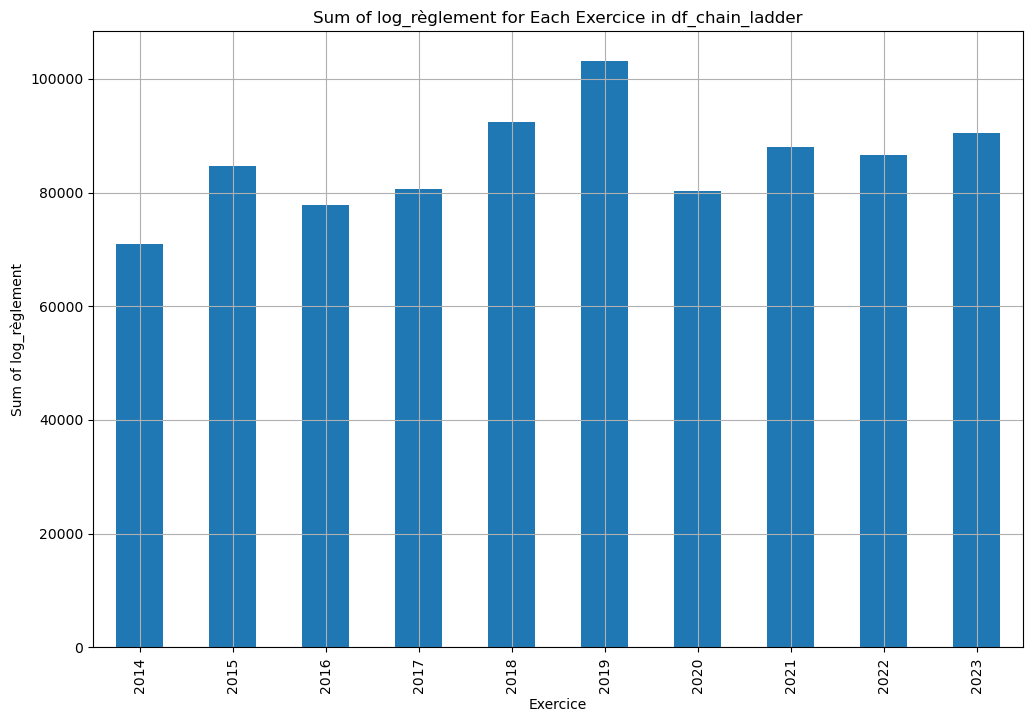

In [25]:
# Group by 'exercice' and calculate the sum of 'log_règlement'
sum_log_reglement_chain_ladder = df_chain_ladder.groupby('exercice')['log_règlement'].sum()

# Plot the data
plt.figure(figsize=(12, 8))
sum_log_reglement_chain_ladder.plot(kind='bar')
plt.xlabel('Exercice')
plt.ylabel('Sum of log_règlement')
plt.title('Sum of log_règlement for Each Exercice in df_chain_ladder')
plt.grid(True)
plt.show()

In [26]:
df_chain_ladder.describe()

,exercice,date_survenance,log_règlement
count,87841.000000,87841.000000,87841.000000
mean,2018.594506,2017.484933,9.729844
std,2.820745,3.302067,1.715368
min,2014.000000,1998.000000,7.400077
25%,2016.000000,2015.000000,8.442082
50%,2019.000000,2018.000000,9.345008
75%,2021.000000,2020.000000,10.735409
max,2023.000000,2023.000000,21.841168


inverse function demonstration

In [27]:
sum_reglement_2023 = df[df['exercice'] == 2023]['règlement'].sum()
sum_reglement_2023

sum_reglement_log_règlement_2023 = (np.exp(df[df['exercice'] == 2023]['log_règlement'])).sum() # apply exponential to log_règlement
sum_reglement_log_règlement_2023

print(sum_reglement_2023, sum_reglement_log_règlement_2023)

(sum_reglement_2023 - sum_reglement_log_règlement_2023)/sum_reglement_2023

8608174183.02 8608174183.02


0.0

In [28]:
df_chain_ladder.to_csv('mathurance_chain_ladder_downscaled.csv', index=False)

In [30]:
df = pd.read_csv('mathurance_chain_ladder_downscaled.csv')
df.head()

,exercice,code_produit,sous-branche,date_survenance,log_règlement
0,2021,IN,Incendie,2019,21.841168
1,2018,IN,Incendie,2017,21.812764
2,2019,IN,Incendie,2017,21.683190
3,2016,IN,Incendie,2015,21.658369
4,2022,IN,Incendie,2021,21.444822


**We split the dataset based on the sub-branch after testing for homogeneity. Now, we want to test the entire dataset and the split datasets to observe the differences.**

In [31]:
df_cat_nat = df[df['sous-branche'] == 'CAT-NAT']
df_incendie = df[df['sous-branche'] == 'Incendie']
df_responsabilite_civile = df[df['sous-branche'] == 'Responsabilité Civile']
df_risque_simple = df[df['sous-branche'] == 'Risque simple']

We fill missing values with weighted mean after testing the stability on MATLAB. The weighted mean approach ensures that the missing values are filled in a way that maintains the overall trend and distribution of the data. This method is particularly useful in the context of claims triangles, where accurate estimation of missing values is crucial for reliable predictions and analysis.

In [32]:
def fill_upper_triangle_weighted(triangle, target_year=2014):
    """
    Fills missing values (zeros) in the upper triangle for accident years before target_year 
    using weighted averages based on known values from later years.
    
    Parameters:
    - triangle (pd.DataFrame): Upper triangular DataFrame with accident years as index 
                               and development lags as columns (numeric: 0, 1, 2, ...).
    - target_year (int): Year before which all zeros should be filled (default: 2014).
    
    Returns:
    - pd.DataFrame: Completed upper triangular DataFrame with non-zero values for years before target_year.
    """
    # Ensure triangle is a DataFrame with numeric columns
    if not isinstance(triangle, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")
    
    # Convert columns to numeric, handling any non-numeric issues
    triangle.columns = pd.to_numeric(triangle.columns, errors='coerce')
    if triangle.columns.isnull().any():
        raise ValueError("Columns must be numeric lag indices.")
    
    # Ensure index is numeric (accident years)
    triangle.index = pd.to_numeric(triangle.index, errors='coerce')
    if triangle.index.isnull().any():
        raise ValueError("Index must be numeric accident years.")
    
    # Replace NaNs with 0s to ensure consistent handling
    filled_triangle = triangle.fillna(0).copy()
    n_rows = len(filled_triangle.index)  # Number of accident years
    n_cols = len(filled_triangle.columns)  # Number of development lags

    # Sort index to ensure chronological order
    filled_triangle = filled_triangle.sort_index()

    # First pass: Fill zeros for years before target_year with weighted averages
    for year in filled_triangle.index:
        if year < target_year:  # Only fill for years before 2014
            row_idx = filled_triangle.index.get_loc(year)  # Get the positional index of the year
            
            # For each lag (column), fill zeros in the upper triangle for this year
            for col in range(n_cols):
                # Check if this position is in the upper triangle (row_idx <= col)
                if row_idx <= col and filled_triangle.iloc[row_idx, col] == 0:
                    # Get all non-zero values in the column from years >= target_year
                    known_values = filled_triangle.loc[filled_triangle.index >= target_year, col][
                        filled_triangle.loc[filled_triangle.index >= target_year, col] != 0
                    ]
                    
                    if not known_values.empty:
                        # Use the mean of known values from 2014 and later
                        avg_value = known_values.mean()
                        # Apply a weight based on row position relative to the column (1-based)
                        weight = (row_idx + 1) / (col + 1)  # 1-based weighting
                        filled_triangle.iloc[row_idx, col] = max(0, avg_value * weight)
                    else:
                        # Fallback: Use global mean of non-zero values if no known values exist
                        non_zero_values = filled_triangle[filled_triangle != 0].values.flatten()
                        global_mean = np.mean(non_zero_values) if len(non_zero_values) > 0 else 0
                        weight = (row_idx + 1) / (col + 1)
                        filled_triangle.iloc[row_idx, col] = max(0, global_mean * weight)

    # Second pass: Ensure no zeros remain for years before target_year, using column means from later years
    for year in filled_triangle.index:
        if year < target_year:
            row_idx = filled_triangle.index.get_loc(year)
            for col in range(n_cols):
                if filled_triangle.iloc[row_idx, col] == 0:
                    # Use mean of non-zero values in this column from years >= target_year
                    column_data = filled_triangle.loc[filled_triangle.index >= target_year, col]
                    column_mean = column_data[column_data != 0].mean()
                    if np.isnan(column_mean) or column_mean == 0:
                        # Fallback to global mean
                        non_zero_values = filled_triangle[filled_triangle != 0].values.flatten()
                        column_mean = np.mean(non_zero_values) if len(non_zero_values) > 0 else 0
                    filled_triangle.iloc[row_idx, col] = max(0, column_mean)

    
    return filled_triangle

In [36]:
def create_claims_triangle(df):
    """
    Create a claims triangle compatible with predict_lower_triangle_with_validation.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with columns 'exercice' (evaluation year),
                         'date_survenance' (occurrence year or datetime),
                         and 'règlement' (payment amount).
    
    Returns:
    - pd.DataFrame: Claims triangle with accident years as index and dev lags as columns.
    """
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Ensure date_survenance is numeric (year); convert if datetime
    if pd.api.types.is_datetime64_any_dtype(df['date_survenance']):
        df['date_survenance'] = df['date_survenance'].dt.year
    
    # Ensure exercice is numeric (year)
    if not pd.api.types.is_numeric_dtype(df['exercice']):
        raise ValueError("'exercice' must be numeric (year).")
    
    # Calculate development lag (calendar year - occurrence year)
    df['dev_lag'] = df['exercice'] - df['date_survenance']
    
    # Check for negative lags (invalid data)
    if (df['dev_lag'] < 0).any():
        raise ValueError("Negative development lags detected. Check 'exercice' and 'date_survenance'.")
    
    # Pivot to create claims triangle
    claims_triangle = df.pivot_table(
        index='date_survenance',  # Rows are occurrence years
        columns='dev_lag',        # Columns are development lags (0, 1, 2, ...)
        values='log_règlement',       # Aggregated payment amounts
        aggfunc='sum'
    ).fillna(0)
    
    # Ensure columns are sorted and sequential (0, 1, 2, ...)
    max_lag = claims_triangle.columns.max()
    all_lags = range(max_lag + 1)
    claims_triangle = claims_triangle.reindex(columns=all_lags, fill_value=0)
    claims_triangle = fill_upper_triangle_weighted(claims_triangle)
    return claims_triangle

In [37]:
claims_triangle_incendie = create_claims_triangle(df_incendie)
claims_triangle_cat_nat = create_claims_triangle(df_cat_nat)
claims_triangle_responsabilite_civile = create_claims_triangle(df_responsabilite_civile)
claims_triangle_risque_simple = create_claims_triangle(df_risque_simple)
claims_traingle = create_claims_triangle(df)

In [38]:
claims_triangle_incendie

dev_lag,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date_survenance,,,,,,,,,,,,,,,,,,,,
2002,23883.172146,9851.094727,1584.344458,539.318653,250.247090,141.477949,66.134657,24.749463,26.797645,40.479638,0.000000,0.000000,0.000000,13.384732,0.000000,0.000000,25.511906,0.000000,0.000000,0.000000
2003,23883.172146,19702.189454,3168.688917,1078.637307,500.494181,282.955899,132.269315,49.498926,53.595291,80.959277,0.000000,0.000000,0.000000,0.000000,12.133242,0.000000,17.184021,10.476624,0.000000,0.000000
2004,23883.172146,19702.189454,4753.033375,1617.955960,750.741271,424.433848,198.403972,74.248389,80.392936,121.438915,96.692959,0.000000,0.000000,9.885833,0.000000,10.434116,0.000000,31.920658,0.000000,10.085809
2005,23883.172146,19702.189454,4753.033375,2157.274613,1000.988361,565.911797,264.538629,98.997853,107.190582,17.799301,44.533066,20.712165,0.000000,0.000000,28.328665,13.612546,24.773628,0.000000,82.473871,0.000000
2006,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,707.389747,330.673287,123.747316,109.709423,36.406551,50.500499,13.250063,11.911108,32.084535,10.343032,32.206787,42.140691,27.657134,0.000000,0.000000
2007,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,848.867696,396.807944,67.287238,231.486173,147.256402,0.000000,10.203768,114.273645,9.221499,22.150106,14.452648,0.000000,0.000000,0.000000,0.000000
2008,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,848.867696,176.033385,97.999179,159.410600,50.839673,18.694904,128.692726,64.127737,0.000000,0.000000,42.632832,0.000000,0.000000,0.000000,0.000000
2009,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,502.748359,260.659399,122.376808,95.306366,115.256245,205.634855,98.037146,227.886222,0.000000,14.675363,0.000000,0.000000,0.000000,0.000000,0.000000
2010,23883.172146,19702.189454,4753.033375,2157.274613,586.969780,631.226757,104.563315,155.885410,75.377155,244.136695,184.447042,381.327718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
claims_triangle_risque_simple

dev_lag,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
date_survenance,,,,,,,,,,,,,,,,,,,,,
1998,3704.136665,1289.271566,283.073822,115.410443,96.152497,65.597747,21.952401,5.631472,5.860934,19.280249,...,0,0,0,24.584531,0,8.853665,0,0,0,8.853665
2002,3704.136665,2578.543132,566.147645,230.820886,192.304993,131.195494,43.904801,11.262944,11.721867,38.560499,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000
2004,3704.136665,2578.543132,849.221467,346.231330,288.457490,196.793241,65.857202,16.894416,17.582801,57.840748,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000
2006,3704.136665,2578.543132,849.221467,461.641773,384.609987,262.390988,87.809603,22.525888,15.934983,45.564349,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000
2007,3704.136665,2578.543132,849.221467,461.641773,480.762483,327.988735,109.762003,35.643596,54.654997,19.766554,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000
2008,3704.136665,2578.543132,849.221467,461.641773,480.762483,393.586482,18.725928,34.277178,35.165602,115.681496,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000
2009,3704.136665,2578.543132,849.221467,461.641773,480.762483,63.506971,44.927319,42.348239,9.047821,38.993640,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000
2010,3704.136665,2578.543132,849.221467,461.641773,278.017217,353.946559,19.902390,8.637625,100.636641,443.891447,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000
2011,3704.136665,2578.543132,849.221467,1621.464007,1119.997877,528.385634,230.054535,618.598862,1107.973938,462.248917,...,0,0,0,0.000000,0,0.000000,0,0,0,0.000000


<div align="center">
    <h1 style="font-family: Arial, sans-serif; color: #2E86C1;">Chain Ladder</h1>
</div>


In [40]:
import pandas as pd
import numpy as np

def chain_ladder_method(df):
    """
    Applies the Chain Ladder method to a claims triangle DataFrame.
    Args:
        df (pd.DataFrame): Input claims triangle with accident years as index and dev lags as columns.
    Returns:
        pd.DataFrame: Cumulative triangle with projected values.
        np.ndarray: Development factors (ratios).
    """
    # Make a copy to avoid modifying the input DataFrame
    triangle_df = df.copy().astype(float)
    
    # Step 1: Convert to cumulative sums row-wise
    for row in triangle_df.index:
        for col in triangle_df.columns[1:]:  # Start from second column
            triangle_df.loc[row, col] += triangle_df.loc[row, triangle_df.columns[triangle_df.columns.get_loc(col) - 1]]

    # Step 2: Calculate development factors (ratios)
    ratios = np.zeros(len(triangle_df.columns) - 1)
    for col_idx in range(len(triangle_df.columns) - 1):
        current_col = triangle_df.columns[col_idx]
        next_col = triangle_df.columns[col_idx + 1]
        
        # Sum only rows where next period is non-zero (fully developed)
        valid_rows = triangle_df[next_col] > 0
        numerator = triangle_df.loc[valid_rows, next_col].sum()
        denominator = triangle_df.loc[valid_rows, current_col].sum()
        
        ratios[col_idx] = numerator / denominator if denominator != 0 else 1.0

    # Step 3: Fill in the triangle using ratios
    for row in triangle_df.index:
        for col_idx in range(len(triangle_df.columns) - 1):
            current_col = triangle_df.columns[col_idx]
            next_col = triangle_df.columns[col_idx + 1]
            if triangle_df.loc[row, next_col] == 0:  # If future period is missing
                # Apply ratios to fill remaining columns
                for future_idx in range(col_idx, len(triangle_df.columns) - 1):
                    current_val = triangle_df.loc[row, triangle_df.columns[future_idx]]
                    triangle_df.loc[row, triangle_df.columns[future_idx + 1]] = current_val * ratios[future_idx]
                break

   
    return triangle_df

In [41]:

completed_triangle_cat_nat = chain_ladder_method(claims_triangle_cat_nat)
completed_triangle_incendie = chain_ladder_method(claims_triangle_incendie)
completed_triangle_responsabilite_civile = chain_ladder_method(claims_triangle_responsabilite_civile)
completed_triangle_risque_simple = chain_ladder_method(claims_triangle_risque_simple)

In [42]:
def sum_diagonal(df):
    tri= df.copy()
    matrix = tri.to_numpy()
    rows, cols = matrix.shape
    # Get the number of rows and columns

    
    # Initialize the sum
    diagonal_sum = 0
    
    # Start from the last row and second column
    i = rows-1   # Last row
    j = 1         # Second column
    
    # Iterate until we reach the second row and last column
    while i >= 1 and j < cols:
        diagonal_sum += (matrix[i][j])
        i -= 1  # Move up one row
        j += 1  # Move right one column
    
    return diagonal_sum


In [43]:
claims_triangle_incendie

dev_lag,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date_survenance,,,,,,,,,,,,,,,,,,,,
2002,23883.172146,9851.094727,1584.344458,539.318653,250.247090,141.477949,66.134657,24.749463,26.797645,40.479638,0.000000,0.000000,0.000000,13.384732,0.000000,0.000000,25.511906,0.000000,0.000000,0.000000
2003,23883.172146,19702.189454,3168.688917,1078.637307,500.494181,282.955899,132.269315,49.498926,53.595291,80.959277,0.000000,0.000000,0.000000,0.000000,12.133242,0.000000,17.184021,10.476624,0.000000,0.000000
2004,23883.172146,19702.189454,4753.033375,1617.955960,750.741271,424.433848,198.403972,74.248389,80.392936,121.438915,96.692959,0.000000,0.000000,9.885833,0.000000,10.434116,0.000000,31.920658,0.000000,10.085809
2005,23883.172146,19702.189454,4753.033375,2157.274613,1000.988361,565.911797,264.538629,98.997853,107.190582,17.799301,44.533066,20.712165,0.000000,0.000000,28.328665,13.612546,24.773628,0.000000,82.473871,0.000000
2006,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,707.389747,330.673287,123.747316,109.709423,36.406551,50.500499,13.250063,11.911108,32.084535,10.343032,32.206787,42.140691,27.657134,0.000000,0.000000
2007,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,848.867696,396.807944,67.287238,231.486173,147.256402,0.000000,10.203768,114.273645,9.221499,22.150106,14.452648,0.000000,0.000000,0.000000,0.000000
2008,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,848.867696,176.033385,97.999179,159.410600,50.839673,18.694904,128.692726,64.127737,0.000000,0.000000,42.632832,0.000000,0.000000,0.000000,0.000000
2009,23883.172146,19702.189454,4753.033375,2157.274613,1251.235451,502.748359,260.659399,122.376808,95.306366,115.256245,205.634855,98.037146,227.886222,0.000000,14.675363,0.000000,0.000000,0.000000,0.000000,0.000000
2010,23883.172146,19702.189454,4753.033375,2157.274613,586.969780,631.226757,104.563315,155.885410,75.377155,244.136695,184.447042,381.327718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
def evaluate_chain_ladder(train_year, test_year, df):
    """
    Evaluates the Chain Ladder method for a given training year and test year.
    
    Parameters:
    - train_year (int): The year up to which data is used for training (e.g., 2022).
    - test_year (int): The year for which predictions are made and evaluated (e.g., 2023).
    - df (pd.DataFrame): DataFrame with 'exercice' (year) and 'règlement' (claims) columns.
    
    Returns:
    - dict: Contains actual sum, predicted sum, and MSE.
    """
    
    # Step 1: Calculate the actual sum of règlement for the test year
    sum_reglement_test = (df[df['exercice'] == test_year]['log_règlement'].sum())
    print(f"Sum of règlement in {test_year}: {sum_reglement_test}")
    
    # Step 2: Filter DataFrame up to the training year
    df_to_train_year = df[df['exercice'] <= train_year]
    
    # Step 3: Create and complete the claims triangle
    claims_triangle_to_train_year = create_claims_triangle(df_to_train_year)
    completed_triangle_to_train_year = chain_ladder_method(claims_triangle_to_train_year)
    
    # Step 4: Calculate the predicted sum of règlement for the test year
    predicted_sum_reglement_test = sum_diagonal(completed_triangle_to_train_year)
    print(f"Predicted sum of règlement in {test_year}: {predicted_sum_reglement_test}")
    
    # Step 5: Calculate MSE between actual and predicted values
    mse = mean_squared_error([sum_reglement_test], [predicted_sum_reglement_test])
    print(f"Mean Squared Error for {test_year}: {mse}")
    
  



In [47]:
evaluate_chain_ladder(2022, 2023, df_incendie)

Sum of règlement in 2023: 54021.10030508757
Predicted sum of règlement in 2023: 852047.2937968798
Mean Squared Error for 2023: 636845805498.9995


In [48]:
evaluate_chain_ladder(2019, 2020, df_cat_nat)

Sum of règlement in 2020: 9.429934431290333
Predicted sum of règlement in 2020: 132.3487753761442
Mean Squared Error for 2020: 15109.041459226284


In [49]:
evaluate_chain_ladder(2022, 2023, df_responsabilite_civile)

Sum of règlement in 2023: 31427.545468705914
Predicted sum of règlement in 2023: 364742.5967124838
Mean Squared Error for 2023: 111098923385.64226


In [50]:
evaluate_chain_ladder(2022, 2023, df_risque_simple)

Sum of règlement in 2023: 5029.043868085189
Predicted sum of règlement in 2023: 182625.55968829003
Mean Squared Error for 2023: 31540522431.476265


In [51]:
evaluate_chain_ladder(2022, 2023, df)

Sum of règlement in 2023: 90477.68964187868
Predicted sum of règlement in 2023: 1674530.3952875435
Mean Squared Error for 2023: 2509222974263.351


<div align="center">
    <h1 style="font-family: Arial, sans-serif; color: #2E86C1;">LSTM model</h1>
</div>


In [52]:
def predict_lower_triangle_with_validation(df_triangle, train_end_year=2022, predict_year=2023, epochs=100, batch_size=16):
    """
    Train on data up to train_end_year and predict the row for predict_year with scaling.
    
    Parameters:
    - df_triangle (pd.DataFrame): Development triangle with accident years as index and lags as columns.
    - train_end_year (int): Last year of training data (default: 2022).
    - predict_year (int): Year to predict (default: 2023).
    - epochs (int): Number of training epochs (default: 100).
    - batch_size (int): Batch size for training (default: 16).
    
    Returns:
    - pd.DataFrame: Predicted triangle.
    - dict: Performance metrics for observed lags in predict_year.
    """
    # Ensure columns are numeric lags
    df_triangle.columns = pd.to_numeric(df_triangle.columns, errors='coerce')
    if df_triangle.columns.isnull().any():
        raise ValueError("Columns must be numeric lag indices.")
    
    # Split data: training up to train_end_year
    train_df = df_triangle[df_triangle.index <= train_end_year].copy()
    full_triangle = df_triangle.copy()
    num_lags = len(df_triangle.columns)
    max_seq_len = num_lags - 1

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.values.reshape(-1, 1)).reshape(train_df.shape)
    train_df_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)

    # Step 1: Create training sequences
    sequences = []
    targets = []
    for t in train_df.index:
        observed_k = min(num_lags, train_end_year - t + 1)
        for k in range(1, observed_k):
            seq = train_df_scaled.loc[t, 0:k].values
            target = train_df_scaled.loc[t, k]
            sequences.append(seq)
            targets.append(target)

    if not sequences:
        raise ValueError("No training sequences generated.")

    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, dtype='float32', padding='pre', value=0.0)
    padded_sequences = padded_sequences[..., np.newaxis]
    targets = np.array(targets, dtype='float32')

    # Step 2: Build and train LSTM model
    model = Sequential([
        Input(shape=(max_seq_len, 1)),  # Replace input_shape with Input layer
        Masking(mask_value=0.0),
        LSTM(32, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(padded_sequences, targets, epochs=epochs, batch_size=batch_size, 
              validation_split=0.2, verbose=0)

    # Step 3: Predict the row for predict_year
    predicted_triangle = full_triangle.copy()
    t = predict_year
    observed_k = train_end_year - t  # -1 for 2023 with train_end_year=2022

    # Predict lag 0 based on average scaled lag 0 from training data, then unscale
    avg_lag0_scaled = train_df_scaled[0].mean()
    predicted_lag0_scaled = avg_lag0_scaled  # Simple baseline; could use a separate model
    predicted_lag0 = scaler.inverse_transform([[predicted_lag0_scaled]])[0, 0]
    predicted_triangle.loc[t, 0] = predicted_lag0
    current_seq = [predicted_lag0_scaled]

    # Predict remaining lags in scaled space, then unscale
    for k in range(1, num_lags):
        padded_seq = np.pad(current_seq, (max_seq_len - len(current_seq), 0), 
                            'constant', constant_values=0.0)
        padded_seq = padded_seq[np.newaxis, :, np.newaxis]
        predicted_lag_scaled = model.predict(padded_seq, verbose=0)[0, 0]
        predicted_lag = scaler.inverse_transform([[predicted_lag_scaled]])[0, 0]
        current_seq.append(predicted_lag_scaled)
        predicted_triangle.loc[t, k] = predicted_lag

    # Step 4: Evaluate performance for lag 0
    actual = full_triangle.loc[predict_year, 0]
    predicted = predicted_triangle.loc[predict_year, 0]
    mae = abs(actual - predicted)
    mse = (actual - predicted) ** 2

    metrics = {'MAE': mae, 'MSE': mse}
    return predicted_triangle, metrics



In [53]:
def predict_triangle_LSTM(traingle,train_end_year, predict_year):
    # Predict using data up to train_end_year
    predicted_triangle, metrics = predict_lower_triangle_with_validation(traingle, train_end_year=train_end_year, predict_year=predict_year)

 
    print(f"\nPerformance Metrics for {predict_year} Lag 0:")
    print(f"Actual {predict_year} Lag 0: {(traingle.loc[predict_year, 0]):.2f}")
    print(f"Predicted {predict_year} Lag 0: {(predicted_triangle.loc[predict_year, 0]):.2f}")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"MSE: {metrics['MSE']:.2f}")



In [54]:
predict_triangle_LSTM(claims_triangle_risque_simple,train_end_year=2022, predict_year=2023)

/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6691.74285898949' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predicted_triangle.loc[t, k] = predicted_lag
/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6527.056384538261' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predicted_triangle.loc[t, k] = predicted_lag
/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6209.009135077435' has dtype incompatible with int64, pleas


Performance Metrics for 2023 Lag 0:
Actual 2023 Lag 0: 2719.02
Predicted 2023 Lag 0: 3753.39
MAE: 1034.37
MSE: 1069919.18


/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3240.7424183684057' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predicted_triangle.loc[t, k] = predicted_lag
/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2100.3892958460788' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predicted_triangle.loc[t, k] = predicted_lag
/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '886.6528337570122' has dtype incompatible with int64, pl

In [55]:
predict_triangle_LSTM(claims_triangle_cat_nat,train_end_year=2019, predict_year=2020)



Performance Metrics for 2020 Lag 0:
Actual 2020 Lag 0: 9.43
Predicted 2020 Lag 0: 22.73
MAE: 13.30
MSE: 176.80


In [56]:
predict_triangle_LSTM(claims_triangle_responsabilite_civile,train_end_year=2022, predict_year=2023)



Performance Metrics for 2023 Lag 0:
Actual 2023 Lag 0: 14450.30
Predicted 2023 Lag 0: 9229.79
MAE: 5220.51
MSE: 27253682.98


In [57]:
predict_triangle_LSTM(claims_triangle_incendie,train_end_year=2022, predict_year=2023)


Performance Metrics for 2023 Lag 0:
Actual 2023 Lag 0: 25135.41
Predicted 2023 Lag 0: 23823.54
MAE: 1311.87
MSE: 1721002.52


<div align="center">
    <h1 style="font-family: Arial, sans-serif; color: #2E86C1;">Final results</h1>
</div>


In [58]:
predict_triangle_LSTM(claims_traingle,train_end_year=2022, predict_year=2023)



Performance Metrics for 2023 Lag 0:
Actual 2023 Lag 0: 42304.73
Predicted 2023 Lag 0: 36831.12
MAE: 5473.61
MSE: 29960440.21


/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-18.649262034407663' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predicted_triangle.loc[t, k] = predicted_lag
/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-36.45127417011293' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  predicted_triangle.loc[t, k] = predicted_lag
/var/folders/lt/lzstf0g942b2sl1qy9xybfnw0000gn/T/ipykernel_58010/3010838326.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-48.59993812475432' has dtype incompatible with int64, 

In [59]:
evaluate_chain_ladder(2022, 2023, df) 

Sum of règlement in 2023: 90477.68964187868
Predicted sum of règlement in 2023: 1674530.3952875435
Mean Squared Error for 2023: 2509222974263.351


<div align="center">
    <h1 style="font-family: Arial, sans-serif; color: #2E86C1;">Comparison of LSTM Model and Chain Ladder Method</h1>
</div>

The results of the LSTM model are better compared to the Chain Ladder method. The LSTM model provides more accurate predictions and lower error metrics, indicating its superior performance in forecasting future claims.